In [2]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [74]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    if t<=-4.9: 
        v=0
    else:
        blobsize = np.sqrt(2*2*D*(t+5))+1 #normally +10, but making it narrow
        d = np.linalg.norm(np.array([x,y])-blobcentre)    
        v = 300*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [75]:
X = []
Y = []
D = 1 #almost no diffusion
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

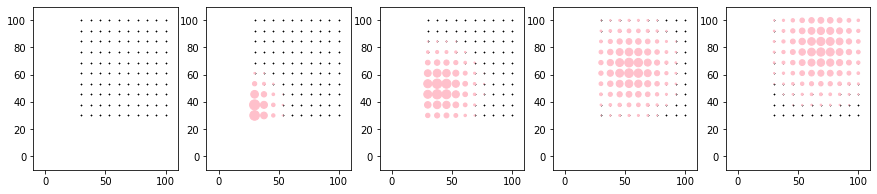

In [76]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [77]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [78]:
#set up our model...
N_feat = 500 #Number of features used to infer the source
k = EQ(20, 1)
res = [50,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

In [79]:
mInfer.computeModelRegressors(Nparticles=20) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...
Computing SS...
Inverting SS...
Computing meanZ
Done


In [80]:
Nsamps = 3
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...
cache miss, computing source from phi...
Computing Source from Phi...


In [81]:
#concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=5,Nparticles=25,interpolateSource=True)
scaleby = [8,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]]
concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=50,Zs=Zs,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(50, 7, 50, 50, 3)
Diffusing particles...


In [82]:
gridps = coords.transpose([1,2,3,0]).copy()
realconc = np.zeros(coords.shape[1:])
for i in np.ndindex(gridps.shape[:3]):
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

In [83]:
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

In [84]:
sourcemean.shape

(50, 50, 50)

In [85]:
concmean.shape

(7, 50, 50)

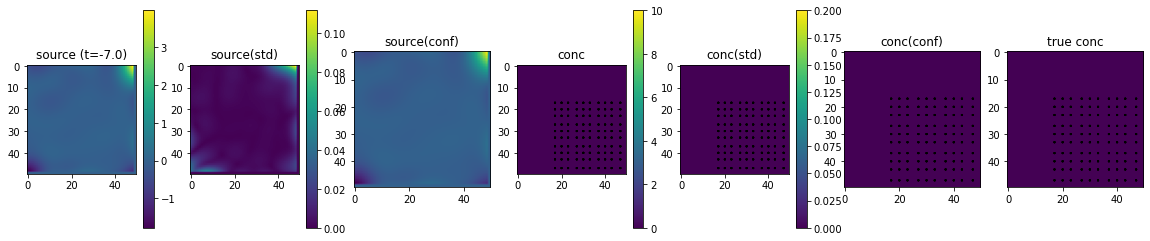

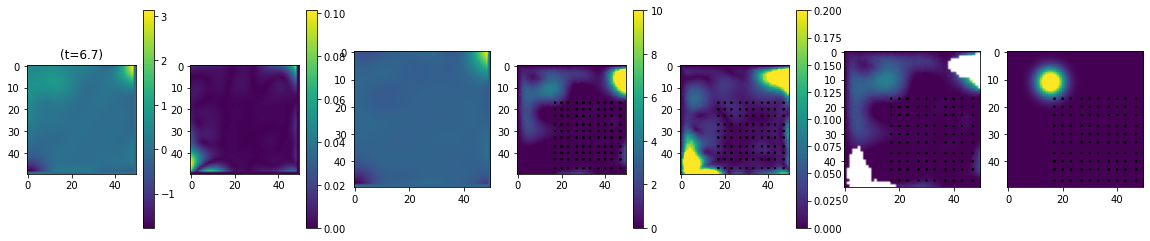

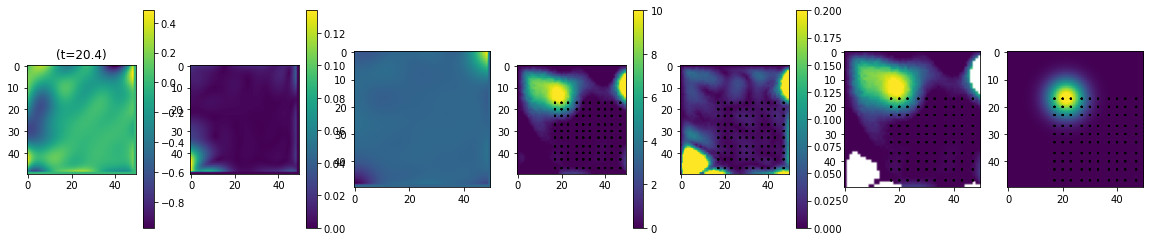

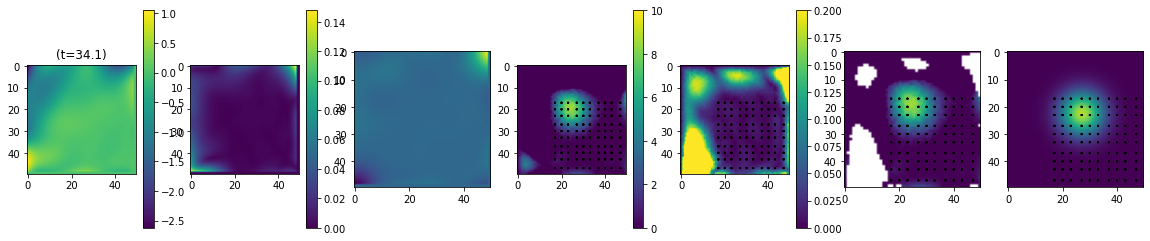

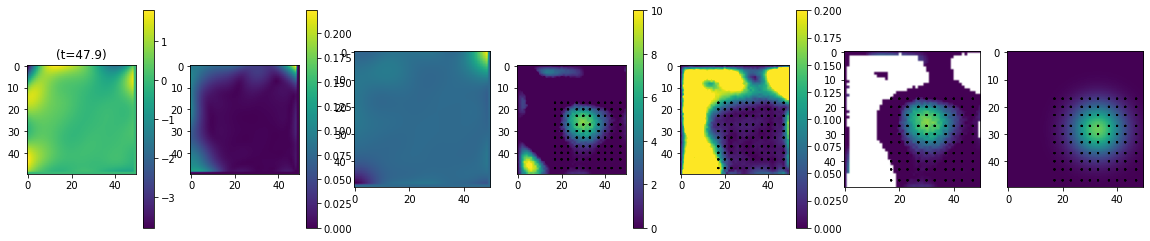

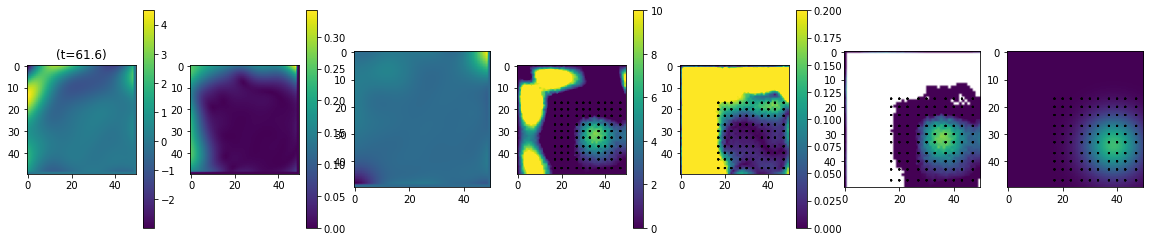

In [134]:
for tsamp in range(0,int(mInferCoords.shape[1]/scaleby[0]),1):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    t = mInferCoords[0,tsamp*scaleby[0],0,0]
    if tsamp==0: 
        plt.title('source (t=%0.1f)' % t)
    else:
        plt.title('(t=%0.1f)' % t)
    plt.imshow(sourcemean[tsamp*scaleby[0],:,:])
    plt.colorbar()
    #plt.clim([-1,1])
    
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('source(std)')
    plt.imshow(np.sqrt(sourcevar[tsamp*scaleby[0],:,:]))
    plt.colorbar()
    
    
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('source(conf)')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp*scaleby[0],:,:])<2
    plt.imshow(vals,alpha=alphas.astype(float))

    
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(concmean[tsamp,:,:])
    plt.colorbar()
    plt.clim([0,10])
    
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('conc(std)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    plt.clim([0,0.2])
    plt.colorbar()
    

    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<0.15
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([0,10])
    
    plt.subplot(1,7,7)
    if tsamp==0: plt.title('true conc')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(realconc[tsamp,:,:])
    plt.clim([0,10])

In [115]:
Phi = []
for i,phi in enumerate(mInfer.kernel.getPhi(coords)):
    Phi.append(phi)
Phi = np.array(Phi)

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [125]:
coords.shape

(3, 7, 50, 50)

In [129]:
def getamax(a):
    return np.unravel_index(a.argmax(), a.shape)

In [131]:
maxsourceargs = getamax(sourcemean[::scaleby[0],:,:])

In [148]:
np.max(sourcemean[::scaleby[0],:,:])

4.488357597929784

In [152]:
#direction of maximum
phimaxz = np.array(list(mInfer.kernel.getPhi(coords[:,maxsourceargs[0],maxsourceargs[1],maxsourceargs[2]])))

In [153]:
np.sum(meanZ*phimaxz)

4.7798554381604

In [48]:
newvecA@np.array([29.5,0])

array([108.74, 108.74,  61.04,  61.04])

In [92]:
newvecA,newvecb

(array([[ 3.69,  0.  ],
        [ 3.69,  0.  ],
        [ 2.07, 19.59],
        [ 2.07, 19.59]]),
 array([-30.98,   9.36,  -0.45,  -0.46]))

[0.99 0.99]


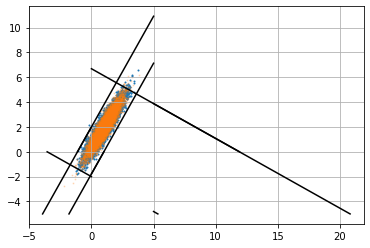

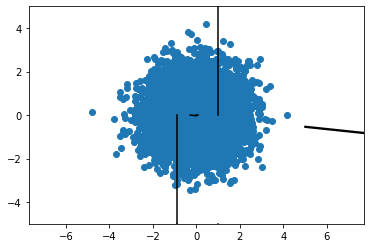

In [99]:
mean = np.array([1,2])
cov = np.array([[1.81,2.7],[2.7,4.81]])/4
rot = np.array([[0,1],[-1,0]])
prec = np.linalg.inv(cov)
#L = np.linalg.cholesky(cov)
Lprec = np.linalg.cholesky(prec)
Lcov = np.linalg.cholesky(cov)
Linvprec = np.linalg.inv(Lprec)
#unitr = np.random.randn(1000,2)

#compute samples
temp = np.random.multivariate_normal(mean,cov,10000)

#demo that the samples transformed by -mean and the L of the precision give the unit normal
unitr = (temp-mean)@Lprec 

#and one computes samples from the original dist...
temp2 = unitr@Lcov.T+mean

#how we handle a plane...
myvecA = []
myvecb = []
myvecA.append(prec[:,0])
myvecb.append(prec[:,0].T @ np.array([0,2]))
myvecA.append(prec[:,0])
myvecb.append(prec[:,0].T @ np.array([1,0]))
myvecA.append(prec[:,0]@rot)
myvecb.append((prec[:,0]@rot).T @ np.array([0,-2]))
myvecA.append(prec[:,0]@rot)
myvecb.append((prec[:,0]@rot).T @ np.array([3,5]))
myvecA = np.array(myvecA)
myvecb = np.array(myvecb)

np.set_printoptions(precision=2,suppress=True)
newvecA = myvecA @ Linvprec.T

#newvecb = myvecb-myvecA@mean
newvecb = newvecA[:,0]*(myvecA[:,0]/newvecb)
newvecb-=myvecA@mean

plt.figure()
plt.scatter(temp[:,0],temp[:,1],1,alpha=1)
plt.scatter(temp2[:,0],temp2[:,1],1,alpha=0.2)
plt.axis('equal')
plt.grid()
for A,b in zip(myvecA,myvecb):
    plt.plot([b/A[0],0],[0,b/A[1]],'k-')
    plt.plot([(b+A[1]*5)/A[0],5],[-5,(b-A[0]*5)/A[1]],'k-')
plt.figure()
plt.scatter(unitr[:,0],unitr[:,1])

for A,b in zip(newvecA,newvecb):
    plt.plot([b/A[0],0],[0,b/A[1]],'k-')
    plt.plot([(b+A[1]*5)/A[0],5],[-5,(b-A[0]*5)/A[1]],'k-')
plt.axis('equal')
plt.xlim([-5,5])
plt.ylim([-5,5])
print(np.std(unitr,0))

In [271]:
L = np.linalg.cholesky(cov)
L@L.T

array([[1.81, 2.7 ],
       [2.7 , 4.81]])

In [294]:
temp.shape

(10000, 2)

array([[ -167.70223336,  1067.54564405, -1010.23701089, ...,
           -2.51071512,    -6.44613008,     2.38867805],
       [ -343.7488193 ,  1075.54731004, -1165.84675453, ...,
           -2.52099046,    -6.44275344,     2.38760206],
       [ -532.05221249,  1075.28030114, -1327.75956609, ...,
           -2.53276703,    -6.43926602,     2.38604496],
       ...,
       [  224.86350544,   136.2440902 ,  -945.69233646, ...,
           -2.53020275,    -6.40138802,     2.33678149],
       [  140.40841024,   137.23822527,  -988.07238597, ...,
           -2.51880193,    -6.39740944,     2.34258628],
       [ -874.05428273,  -180.79062658, -1453.15074006, ...,
           -2.55737477,    -6.39512156,     2.28992076]])

In [186]:
np.argmin(A@phimaxz)

15836

In [193]:
a = np.argmin(np.sum(mInfer.kernel.W**2,1))
mInfer.kernel.W[a,:]

array([-0.16374472, -0.00335254,  0.03982345])

In [201]:
x0 = np.zeros(mInfer.kernel.W.shape[0])
x0[a] = np.sign(np.mean(Phi[a,:,:,:]))

In [218]:
np.argmin(A@x0), np.min(A@x0)

(17450, 0.04801018505089287)

In [300]:
from hitandrun.hitandrun import HitAndRun
from hitandrun.polytope import Polytope
A = -Phi.reshape([Phi.shape[0],np.prod(Phi.shape[1:])]).T.astype(np.float64)
A = np.r_[A,phimaxz[None,:]]
b = np.zeros(len(A)).astype(np.float64)
b[-1]=2


#meanZ, covZ
precZ = np.linalg.inv(covZ)
Linv = np.linalg.cholesky(precZ)
L =

#shift A and b and x0 into unit normal space...
#A = (A-meanZ)@Linv
#b = (b-meanZ)@Linv
#x0 = (x0-meanZ)@Linv

#x0 = phimaxz.astype(np.float64)
polytope = Polytope(A=A, b=b) #Ax <= b

hitandrun = HitAndRun(polytope=polytope, starting_point=x0,thin=1)
samples = hitandrun.get_samples(n_samples=1)
checks = samples @ polytope.A.T - b
assert(np.alltrue(checks < 0))

hit-and-run steps:: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


(17501,)

In [246]:
Phi.shape

(500, 7, 50, 50)

In [247]:
samples.shape

(10, 500)

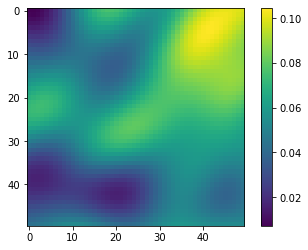

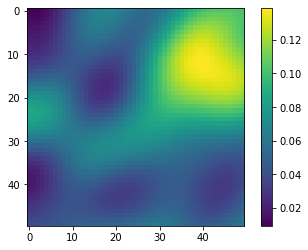

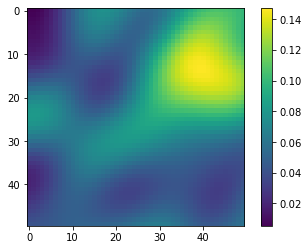

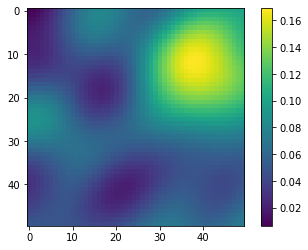

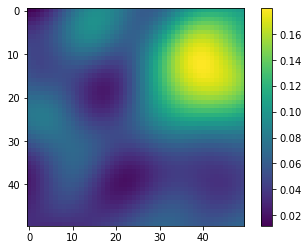

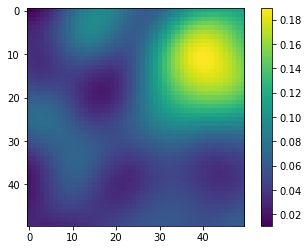

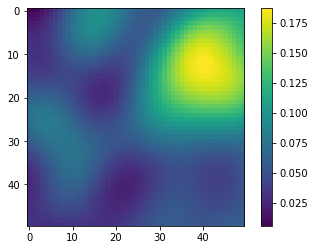

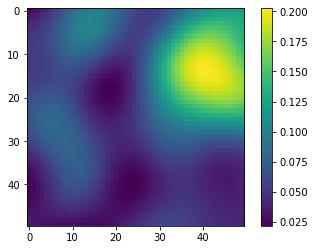

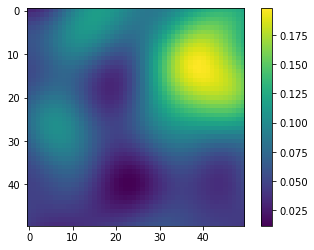

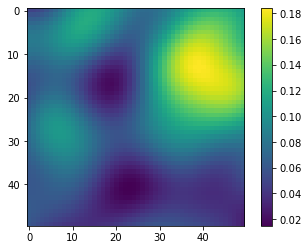

In [248]:
for s in range(10):
    plt.figure()
    plt.imshow((Phi.transpose([1,2,3,0])@samples.T)[4,:,:,s])
    plt.colorbar()

# Trying to memory optimise...

I think we don't need many locations, so maybe don't need to worry about this. (left it for if it's useful later)

In [90]:
coords.shape

(3, 7, 50, 50)

(7, 50, 50)


In [109]:
coords.reshape([3,np.prod(coords.shape[1:])])[:,0]

array([ -7., -10., -10.])

In [101]:
coords[:,0,0,0]

array([ -7., -10., -10.])

In [110]:
for a in coords.reshape([3,np.prod(coords.shape[1:])]).T:
    print(a)
    break

[ -7. -10. -10.]


In [ ]:
for c in coords:
    phi=norm*np.sqrt(2*self.sigma2)*np.cos(np.einsum('i,i...->...',self.W/self.l2,c)+ self.b)
    yield phi
    

def getPhiTranspose(self,coords):
    """
    For each point in coords, returns a vector of length of basis evaluated at each point.
    Arguments:
        coords: map of all (t,x,y) points in the grid
    """
    assert self.W is not None, "Need to call generateFeatures before computing phi."
    norm = 1./np.sqrt(self.N_feat)

    #We assume that we are using the e^-(1/2 * x^2/l^2) definition of the EQ kernel,
    #(in Mauricio's definition he doesn't use the 1/2 factor - but that's less standard).
    #c=np.sqrt(2.0)/(self.l2)
    ####c=1/(self.l2)
    for c in coords:
        phi=norm*np.sqrt(2*self.sigma2)*np.cos(np.einsum('i,i...->...',self.W/self.l2,c)+ self.b)
        yield phi            
            
    